# NEW YORK CITY TAXI - ANALYSIS, RECOMMENDATIONS, PREDICTIONS

# <font color="teal">PART 2 - MODELLING AND PREDICTIONS</font>

This part of research is dedicated to construction of different Machine Learning models to predict Fare and Tip for route with known time and endpoints. Having these models allows quickly predict fares for future trips.

## Objective
Research on question: Can we build a model to predict fare and tip amount given pick up and drop off coordinates, time of day and week?

## Approach
Explore Linear and Random Forest models to predict Fare and Tip based on endpoint locations and hour/weekday of a trip

# 2.1. Read Data from files

In [ ]:
library('lubridate')
library('dplyr')

In [3]:
############### Read Data from files #################################
trips <- read.csv("trips_notebook.csv")
head(trips, 5)

X hack_license                     pickup_datetime     dropoff_datetime   
1 1 AD8751110E6292079EB10EB9481FE1A6 2013-04-04 18:47:45 2013-04-04 19:00:25
2 2 E1B595FD55E4C82C1E213EB17438107A 2013-04-04 17:59:50 2013-04-04 18:21:48
3 3 16BB0D96A0DCC853AEC7F55C8D6C71E0 2013-04-04 18:12:01 2013-04-04 18:25:24
4 4 579C41EA5EC846F8B641A42F9EE3E855 2013-04-04 20:12:57 2013-04-04 20:29:55
5 5 1B4E92431F9DA4D49874EC76E769E874 2013-04-05 02:48:11 2013-04-05 02:51:21
  trip_time_in_secs trip_distance pickup_longitude pickup_latitude
1  759              2.5           -73.95785        40.76532       
2 1318              3.6           -73.98288        40.75499       
3  799              1.9           -73.97812        40.76345       
4 1017              3.6           -74.00637        40.74475       
5  189              0.7           -73.98519        40.75493       
  dropoff_longitude dropoff_latitude fare_amount tip_amount total_amount
1 -73.97627         40.78565         11.0        2.50       15.00       
2 -74.00919         40.71537         16.5        3.60       21.60       
3 -73.95567         40.77664         10.0        3.45       14.95       
4 -73.96166         40.76108         15.0        3.20       19.20       
5 -73.99078         40.74800          4.5        1.10        6.60       
  pickup_hour pickup_weekday
1 18          5             
2 17          5             
3 18          5             
4 20          5             
5  2          6

In [4]:
## Remove contraversial data with the same pickup and dropoff location for some trips
trips <- subset(trips, (pickup_longitude != dropoff_longitude) | (pickup_latitude != dropoff_latitude))

# 2.2. Hypothesis and Research directions

Research on models to predict Fare and Tip amounts for routes with known pickup and dropoff locations
for given hour and weekday.

Preliminary hypothesis that Fare can be quite accurately while Tip is centiment-driven and service quality 
dependant variable.

Analysis required to validate and compare a few models.

# 2.3. Predictive model for Fare and Tip Amounts

## 2.3.1. Direct Calulations of Average Fare and Tip for existing routes

In [5]:
AverageRevenueForTrip <- function (pickup_long, pickup_lat, dropoff_long, dropoff_lat, hour, Weekday, minSamples = 2) 
{
  # Calculate Average Revenue for a trip with given locations hours and weekdays
  #
  # Extract dataset
  ds <- subset(trips, (pickup_longitude == pickup_long) & (pickup_latitude == pickup_lat)
               & (dropoff_longitude == dropoff_long) & (dropoff_latitude == dropoff_lat) 
               & (pickup_hour == hour) & (pickup_weekday == Weekday))
  if (NROW(ds) <= minSamples)
    return(NA)

  av_fare = mean(ds$fare_amount)
  av_tip = mean(ds$tip_amount)
  
  return(c(av_fare, av_tip))
}

In [6]:
# Testing exact calculations for some trips
print(AverageRevenueForTrip(trips$pickup_longitude[30], trips$pickup_latitude[30],
                            trips$dropoff_longitude[30], trips$dropoff_latitude[30], 1, 1))
print(AverageRevenueForTrip(-74.02082, 40.64133, -74.02082, 40.64133, 1, 1))

[1] NA
[1] NA


# 2.4. Build linear model between route endpoints and average fare and tips

## 2.4.1. Analyse merits of linear model

In [7]:
# Check correlation between distance and Fare
print(sprintf("Fare-Distance correlation %s", cor(trips$fare_amount, trips$trip_distance)))
# Observe -> Quite strong correlation

[1] "Fare-Distance correlation 0.924210122909063"


In [8]:
# Check correlation between distance and Fare
print(sprintf("Tip-Distance correlation %s", cor(trips$tip_amount, trips$trip_distance)))
# Observe -> moderate correlation

[1] "Tip-Distance correlation 0.496471492620866"


In [9]:
# Check correlation between distance and Fare
print(sprintf("Tip-Fare correlation %s", cor(trips$tip_amount, trips$fare_amount)))
# Observe -> moderate correlation

[1] "Tip-Fare correlation 0.531356143630276"


Hypothesis:
Good correlation between fare and distance may be the good foundation for linear predictive model

## 2.4.2. Extract model data

In [10]:
# Extarct model_data from large dataset

#sd <- 1:1000 # small dataset
sd <- 1:100000 # moderate dataset
#sd <- 1:nrow(trips) # full dataset
#sd <- sample(nrow(trips), 100000) # Select random 1000000 from trips

modelData <- trips[sd, c("fare_amount", "tip_amount", "trip_distance", "pickup_hour", 
                            "pickup_weekday", "pickup_longitude", "pickup_latitude", 
                            "dropoff_longitude", "dropoff_latitude")]

In [11]:
# Introduce geo_distance column to calculate direct shortest distance between pickups and dropoffs
calcDist <- function (p_long, p_lat, d_long, d_lat) {
  # Calculate Geo Distance between pickup and dropoff distance
  return (sqrt((p_long - d_long)^2 + (p_lat - d_lat)^2))
}

#modelData$geo_distance <- modelData$trip_distance
modelData$geo_distance <- as.numeric(calcDist(modelData$pickup_longitude, modelData$pickup_latitude, 
                                              modelData$dropoff_longitude, modelData$dropoff_latitude))

# Check correlation between distance and Fare
print(sprintf("GeoDistance-tripDistance correlation %s", cor(modelData$geo_distance, modelData$trip_distance)))
# Observe -> Quite strong correlation

[1] "GeoDistance-tripDistance correlation 0.916993048489184"


In [ ]:
# Introduce categorical pickup and dropoff columns based on geohashing
library ('geohash')

# Converting geocodes into hashcodes
modelData$pickup_code  <- geohash::gh_encode(modelData$pickup_latitude,  modelData$pickup_longitude)
modelData$dropoff_code <- geohash::gh_encode(modelData$dropoff_latitude, modelData$dropoff_longitude)

In [13]:
# remove unnecessary columns
modelData$pickup_longitude  <- NULL
modelData$pickup_latitude   <- NULL
modelData$dropoff_longitude <- NULL
modelData$dropoff_latitude  <- NULL
head(modelData)

fare_amount tip_amount trip_distance pickup_hour pickup_weekday geo_distance
1 11.0        2.50       2.5           18          5              0.027430828 
2 16.5        3.60       3.6           17          5              0.047554528 
3 10.0        3.45       1.9           18          5              0.026041115 
4 15.0        3.20       3.6           20          5              0.047596908 
5  4.5        1.10       0.7            2          6              0.008904294 
6  6.5        1.00       1.2            6          6              0.013798651 
  pickup_code dropoff_code
1 dr5rvj      dr72h8      
2 dr5ru7      dr5reu      
3 dr5rus      dr5rvp      
4 dr5rgc      dr5ruu      
5 dr5ru7      dr5ru3      
6 dr5ruk      dr5rud

## 2.4.3. Plot Model Data (may be slow for large datasets)

In [14]:
if (nrow(modelData) < 1000)
    plot(modelData$tip_amount,  panel.first=grid(), cex = .5, col="darkcyan",
         ylab="Trip tip", xlab = "Trip number", main = "Trip tip")

In [15]:
if (nrow(modelData) < 1000) {
    plot(modelData$fare_amount, modelData$tip_amount, panel.first=grid(), cex = .5, col="darkcyan",
     ylab="Trip tip", xlab = "Trip Fare", main = "Trip tip vs fare")
    abline(lm(tip_amount ~ fare_amount, data=modelData))
}    

## 2.4.4. Build linear regression model

In [16]:
BuildLinearModel_Fare <- function(ds, printCharts = FALSE) {
  # Build linear model predicting Fare and Tip amount for a trip
  #
  
  # Check correlation
  print(sprintf("Fare-Distance correlation %s", cor(ds$fare_amount, ds$geo_distance))) # >0.85 quite strong correlation

  # Linear model for Fare (will be saved as a global variable)
  fm <<- lm(fare_amount ~ geo_distance + pickup_hour + pickup_weekday, data = ds, model=FALSE, x=FALSE, y=FALSE)
  
  print(summary(fm))
  print(sprintf("Model R^2 Accuracy %s", fm$r.squared))
  
  # Free Up some memory
  fm$fitted.values <<- NULL
  fm$residuals <<- NULL
  fm$effects <<- NULL
  fm$model <<- NULL
  #fm$qr <- NULL

  # Print charts
  if (printCharts) {
    plot(ds$fare_amount, ds$geo_distance, panel.first=grid(), col="darkcyan",
         ylab="Fare", xlab = "Distance", main = "Trip fare vs distance")
    abline(fm$coefficients[1], fm$coefficients[2], col="blue")
  }
}

In [17]:
BuildLinearModel_Tip <- function(ds, printCharts = FALSE) {
  # Build linear model predicting Tip amount for a trip
  #
  
  # Check correlation
  print(sprintf("Tip-Distance correlation %s", cor(ds$tip_amount, ds$geo_distance)))
  print(sprintf("Fare-Tip correlation %s", cor(ds$tip_amount, ds$fare_amount))) 
  
  # Print charts
  if (printCharts) {
    plot(ds$tip_amount, ds$geo_distance, panel.first=grid(),  col="darkcyan",
         ylab="Tip", xlab = "Distance", main = "Trip Tip vs distance")
  }
  
  # Buid Linear model for Fare
  tm <<- lm(tip_amount  ~ geo_distance + pickup_hour + pickup_weekday, data = ds, model=FALSE, x=FALSE, y=FALSE)
  print(summary(tm))
  #print(sprintf("Model R^2 Accuracy %s", tm$r.squared))
  
  tm$fitted.values <<- NULL
  tm$residuals <<- NULL
  tm$effects <<- NULL
  tm$model <<- NULL
  #tm$qr <- NULL
}

In [18]:
BuidlLinearModel <- function (ds, printCharts = FALSE) {
  # Build two models for Fare and Tip
  #
  BuildLinearModel_Fare(ds, printCharts) #### Build Model for Fare
  BuildLinearModel_Tip(ds, printCharts)  #### Build Model for Tip
}

In [19]:
PredictFareTip <- function (geodistance, hour, weekday) {
  # Predict Fare and Tip based on models built
  #
  df = data.frame(geo_distance=geodistance, pickup_hour=hour, pickup_weekday=weekday)
  fare = predict.lm(fm, newdata = df)
  tip  = predict.lm(tm, newdata = df)
  return (c(fare, tip))
}

In [ ]:
gc() ## Free some memory
rm(fm)
rm(tm)

In [21]:
# Build model
BuidlLinearModel(modelData)

[1] "Fare-Distance correlation 0.884559590769722"

Call:
lm(formula = fare_amount ~ geo_distance + pickup_hour + pickup_weekday, 
    data = ds, model = FALSE, x = FALSE, y = FALSE)

Residuals:
    Min      1Q  Median      3Q     Max 
-554.95   -1.64   -0.67    0.85  332.49 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      9.089129   0.413542  21.979  < 2e-16 ***
geo_distance   209.857895   0.349722 600.070  < 2e-16 ***
pickup_hour     -0.020779   0.003209  -6.476 9.46e-11 ***
pickup_weekday  -0.671558   0.057865 -11.606  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.301 on 99996 degrees of freedom
Multiple R-squared:  0.7829,	Adjusted R-squared:  0.7829 
F-statistic: 1.202e+05 on 3 and 99996 DF,  p-value: < 2.2e-16

character(0)
[1] "Tip-Distance correlation 0.411997818536584"
[1] "Fare-Tip correlation 0.453918006571486"

Call:
lm(formula = tip_amount ~ geo_distance + pickup_hour + pi

<font color="maroon">Observation - R^2 for Tip is very low (0.2) pointing to bad model.</font>

## 2.4.5. Making predictions

In [22]:
# Make Predictions
PredictFareTip(geodistance=0.06, hour=3, weekday=4)
PredictFareTip(geodistance=0.012, hour=23, weekday=6)

1         1 
18.932033  2.557185

1         1 
7.1001514 0.7913815

## 2.4.6. Plot train data vs the model (optional)

In [23]:
# Can be slow for large datasets
if (nrow(modelData) < 1000) {
    plot(modelData$geo_distance, modelData$fare_amount, panel.first=grid(), cex = .5, col="darkcyan",
     ylab="Fare", xlab = "Geo-distance", main = "Fare vs distance")
    abline(fm)
}
# Warning -> only two model parameters are used in plotting omitting hour and weekday

## 2.4.7. More complex predictive functions for actual locations

In [24]:
PredictFareTipForRoute <- function (pickup_long, pickup_lat, dropoff_long, dropoff_lat, hour, weekday) {
  # Predict Fare and Tip based on models built and actual endpoint locations
  #
    
  # Calculate geodist based on locations
  geodist <- as.numeric(calcDist(pickup_long, pickup_lat, dropoff_long, dropoff_lat))
  df = data.frame(geo_distance=geodist, pickup_hour=hour, pickup_weekday=weekday)
  fare = predict.lm(fm, newdata = df)
  tip  = predict.lm(tm, newdata = df)
  return (c(fare, tip))
}

In [25]:
# Testing new predictive function
PredictFareTipForRoute(-74.02305, 40.76599, -73.99094, 40.73605, hour=3, weekday=4) # Lincoln Tunnel to Union Square Thurs
PredictFareTipForRoute(-74.02305, 40.76599, -73.99094, 40.73605, hour=23, weekday=6) # Lincoln Tunnel to Union Square Sat

PredictFareTipForRoute(-73.863,40.769, -73.99094, 40.73605, hour=16, weekday=4) # Airport to Manhatten Thur
PredictFareTipForRoute(-73.863, 40.769 , -73.99094, 40.73605, hour=23, weekday=6) # Airport to Manhatten Sat

1         1 
15.553908  2.190416

1         1 
13.795205  1.518274

1         1 
33.795782  4.097572

1         1 
32.307211  3.528151

In [26]:
nrow(modelData)

[1] 100000

## 2.4.8. Linear Distance Model - Results Analysis

In [27]:
### Observations -> For 100, 1M and 15Mln samples R^2 for FARE results are reasonably good - 0.92, 0.7, 0.7
### But not stable for TIP 0.67. 0.25, 0.2

### So, unlike for Fare the model for TIP is not good, and need to be discarded

### Few possible opportunities
#### 1) Use model for Fare and just apply average tip/fare percent (10.6%) for tip
#### 2) Try Random Forest for Tip with geohash codes as categorical variables
#### 3) Try Linear Regression with geohash codes as categorical variables

In [28]:
gc() 
rm(fm) # remove linear model
rm(tm)

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   3190054  170.4  10282099   549.2  17951649  958.8
Vcells 209515130 1598.5 583588540  4452.5 581788380 4438.7

# 2.5. Random Forest Model for Tip prediction

## 2.5.1. Hypothesis

Try to check whether Random Forest may improve Tip prediction results in comparison with Linear model

## 2.5.2. Random forest model construction

In [ ]:
library('randomForest')
library('caret')

In [30]:
# Separate train and test_data
sm <- sample(nrow(modelData), 2*nrow(modelData)/3) # Select randomly from trips allocating 2/3 to train and 1/3 to test data

# Try different model selections to check the accuracy of Tip predicability
#train_data = modelData[sm,c("tip_amount", "pickup_hour", "pickup_weekday", "pickup_code", "dropoff_code")]
#train_data = modelData[sm,c("tip_amount", "geo_distance", "pickup_hour", "pickup_weekday")]
train_data = modelData[sm,c("tip_amount", "fare_amount", "pickup_hour", "pickup_weekday", "geo_distance")]
# make weekday and hour as categorical variables
train_data$pickup_weekday <- as.factor(train_data$pickup_weekday)
train_data$pickup_hour <- as.factor(train_data$pickup_hour)

head(train_data, 2)
str(train_data)

# Test dataset
#test_data = modelData[-sm, c("tip_amount", "pickup_hour", "pickup_weekday", "pickup_code", "dropoff_code")] 
#test_data = modelData[-sm,c("tip_amount", "geo_distance", "pickup_hour", "pickup_weekday")]
test_data = modelData[-sm,c("tip_amount", "fare_amount", "pickup_hour", "pickup_weekday", "geo_distance")]
test_data$pickup_weekday <- as.factor(test_data$pickup_weekday)
test_data$pickup_hour <- as.factor(test_data$pickup_hour)
head(test_data, 2)

tip_amount fare_amount pickup_hour pickup_weekday geo_distance
49894 4.75       18.5        2           7              0.03816930  
59836 1.00       10.0        1           7              0.02384648

'data.frame':	66666 obs. of  5 variables:
 $ tip_amount    : num  4.75 1 0 3.9 2 1 0 0 1 1.35 ...
 $ fare_amount   : num  18.5 10 3.5 19 9 8 11.5 10.5 6.5 4 ...
 $ pickup_hour   : Factor w/ 24 levels "0","1","2","3",..: 3 2 3 2 1 20 2 1 1 24 ...
 $ pickup_weekday: Factor w/ 7 levels "1","2","3","4",..: 7 7 7 7 7 6 7 7 7 6 ...
 $ geo_distance  : num  0.038169 0.023846 0.000443 0.069921 0.027878 ...


tip_amount fare_amount pickup_hour pickup_weekday geo_distance
3 3.45       10.0        18          5              0.02604112  
9 2.80       12.5        18          4              0.02851812

In [31]:
# Call Random Forest regression
rf <- randomForest(tip_amount ~ fare_amount + pickup_hour + pickup_weekday, train_data, ntree = 500)
rf
#str(rf)


Call:
 randomForest(formula = tip_amount ~ fare_amount + pickup_hour +      pickup_weekday, data = train_data, ntree = 500) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 3.974034
                    % Var explained: 18.48

In [32]:
#barchart(rf$importance) ## Print factors importance
rf$importance ## Print factors importance
# advanced factors
caret::postResample(rf$predicted, train_data$tip_amount)

IncNodePurity
fare_amount    66589.9416   
pickup_hour     4979.2137   
pickup_weekday   954.0327

RMSE  Rsquared       MAE 
1.9934979 0.1877532 1.2356323

In [33]:
# RF predictions over test set
predict(rf, test_data) -> prediction
caret::postResample(prediction, test_data$tip_amount)

RMSE  Rsquared       MAE 
1.7927799 0.2240073 1.2396356

In [34]:
str(modelData)

'data.frame':	100000 obs. of  8 variables:
 $ fare_amount   : num  11 16.5 10 15 4.5 6.5 8 7.5 12.5 6.5 ...
 $ tip_amount    : num  2.5 3.6 3.45 3.2 1.1 1 2.1 2.25 2.8 2 ...
 $ trip_distance : num  2.5 3.6 1.9 3.6 0.7 1.2 1.6 0.4 2.4 1.1 ...
 $ pickup_hour   : int  18 17 18 20 2 6 6 19 18 18 ...
 $ pickup_weekday: int  5 5 5 5 6 6 6 5 4 4 ...
 $ geo_distance  : num  0.0274 0.0476 0.026 0.0476 0.0089 ...
 $ pickup_code   : chr  "dr5rvj" "dr5ru7" "dr5rus" "dr5rgc" ...
 $ dropoff_code  : chr  "dr72h8" "dr5reu" "dr5rvp" "dr5ruu" ...


## 2.5.3. Summary on Random Forest for Tip Prediction

Random Forest does not imporove accuracy of prediction of Tip in comparison with Linear Model.
Tip is related to sentiment and quality of service which is hard to measure and predict.
Tip may have some relevannce to some zipcodes, with further analysis required.

#  <font=color="green">2.6. Proposed Final Model for Fare Prediction</font>

## 2.6.1. Random Forest for Fare vs Distance with hour, weekday as categorical variables

In [35]:
# Train Random Forest on train data
rf <- randomForest(fare_amount ~ geo_distance + pickup_hour + pickup_weekday, train_data, ntree = 500)
rf


Call:
 randomForest(formula = fare_amount ~ geo_distance + pickup_hour +      pickup_weekday, data = train_data, ntree = 500) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 18.13386
                    % Var explained: 78.75

In [36]:
rf$importance ## Print factors importance

IncNodePurity
geo_distance   3858775.257  
pickup_hour      81293.659  
pickup_weekday    6023.046

In [37]:
# advanced factors
caret::postResample(rf$predicted, train_data$fare_amount)

RMSE Rsquared      MAE 
4.258386 0.809610 2.371233

## 2.6.2. Test Model on Test Dataset

In [38]:
# RF predictions over test set
predict(rf, test_data) -> prediction
caret::postResample(prediction, test_data$fare_amount)
# Observe -> even better accuracy on test 

RMSE  Rsquared       MAE 
4.0861246 0.8253537 2.4002885

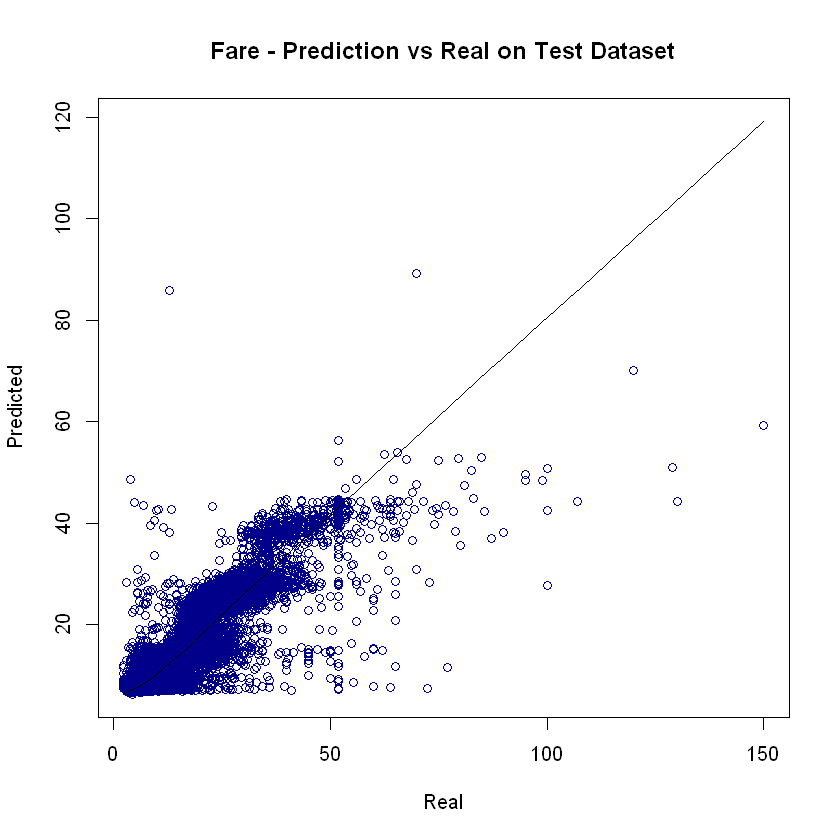

In [39]:
# Show scatter plot predicted vs real
dt <- data.frame(keyName=names(prediction), value=prediction, row.names=NULL)
scatter.smooth(test_data$fare_amount, dt$value, ylab="Predicted", xlab="Real", 
               main = "Fare - Prediction vs Real on Test Dataset", col="darkblue")

## 2.6.3. Real Fare predictions

In [40]:
PredictFareForRoute <- function (pickup_long, pickup_lat, dropoff_long, dropoff_lat, hour, weekday) {
  # Predict Fare based on RF model built and actual endpoint locations
  #
    
  # Calculate geodist based on locations
  geodist <- as.numeric(calcDist(pickup_long, pickup_lat, dropoff_long, dropoff_lat))
  
  # Add another row for features
  nr <- nrow(test_data)
  test_data[nr + 1, c('geo_distance', 'pickup_hour', 'pickup_weekday')] <- c(geodist, hour, weekday)

  p1 = predict(rf, newdata = test_data[nr + 1,])

  return (p1)
}

In [41]:
# Testing new predictive function
PredictFareForRoute(-74.02305, 40.76599, -73.99094, 40.73605, hour=3, weekday=4) # Lincoln Tunnel to Union Square Thurs
PredictFareForRoute(-74.02305, 40.76599, -73.99094, 40.73605, hour=23, weekday=6) # Lincoln Tunnel to Union Square Sat
PredictFareForRoute(-73.863,40.769, -73.99094, 40.73605, hour=16, weekday=4) # Airport to Manhatten Thur
PredictFareForRoute(-73.863, 40.769 , -73.99094, 40.73605, hour=23, weekday=6) # Airport to Manhatten Sat

33335 
13.60149

33335 
13.35392

33335 
31.36408

33335 
28.59336

## 2.7. Conclusion

Random Forest for Fare prediction seems robust model while there is no easy-to-construct reliable model for centiment-driven and unpredictable Tip.